An overbooking simulation model

Uncertainty: 
   - Demand for seats
   - Number of passengers that show up


Assumption: The demand follows a poisson distribution with average estimated by historical data

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#What-if analysis for overbooking
overbookData = pd.read_excel('data/OverbookingData.xlsx')

#Constants
CAPACITY = 134
TICKETPRICE = 314
TRANSFERFEE = 60 #No shows pay for another flight
BUMPEDCOST = 400


In [15]:
def fit_predict_demand(overbookData,
                      simulSize=10000):
    averageDemand  = int(overbookData['Demand'].mean())
    
    showUpRate  = round(overbookData['Rate'].mean(), 2)
        
    predictedDemand = np.random.poisson(lam = averageDemand, size=simulSize) #The demand follows a poison distribution Use timeseries to
    #TODO: uncover seasonality effects
    return(showUpRate,
           predictedDemand)

In [21]:
def calculate_cost(showUpRate,predictedDemand,
                   overbookingLim =13): #This parameter can be optimized 
    
    bookingCapacity = CAPACITY + overbookingLim
    
    booked  = np.array([min(x, bookingCapacity) for x in predictedDemand])
    
    readyToBoard = np.array([np.random.binomial(n= x, p= showUpRate) for x in booked])
    
    noShows =booked - readyToBoard
    
    boardingTheFlight = np.array([min(x, CAPACITY) for x in readyToBoard])
    
    bumpedPassengers = readyToBoard - boardingTheFlight
    
    ticketRevenue = booked * TICKETPRICE
    
    noShowRevenue = TRANSFERFEE * noShows
    
    overbookingCost = BUMPEDCOST * bumpedPassengers
    
    netRevenue = (ticketRevenue + noShowRevenue) - overbookingCost
    
    return(netRevenue,
          bumpedPassengers)

In [22]:
def get_summary(netRevenue,
          bumpedPassengers):
    
    summarySimul = pd.DataFrame({'stats' : ['mean','std','min','max',
                         'median'],
                 'NetRev' : [netRevenue.mean(),netRevenue.std(),
                             netRevenue.min(), netRevenue.max(),
                             np.median(netRevenue)],
                 'BumpPass' : [bumpedPassengers.mean(),
                               bumpedPassengers.std(),
                               bumpedPassengers.min(),
                               bumpedPassengers.max(),
                               np.median(bumpedPassengers)]})
    return(summarySimul)

In [23]:
def plot_distributions(bumpedPassengers,netRevenue):
    bumpedPassengersTable =  np.unique(bumpedPassengers, return_counts=True)
    
    
    fig = plt.figure(figsize=(12, 5))
    ax = fig.add_subplot(121)
    

    plt.bar(bumpedPassengersTable[0], bumpedPassengersTable[1])
    plt.xlabel('Bumped passengers')
    plt.ylabel('Frequency')
    
    ax = plt.subplot(122)
    plt.hist(netRevenue)
    plt.xlabel('Revenue')
    plt.ylabel('Frequency')

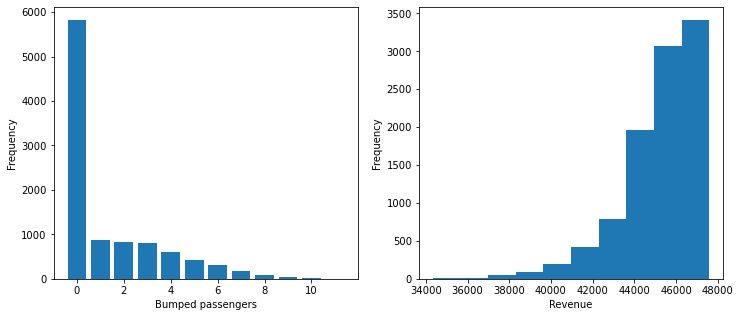

In [24]:
showUpRate, predictedDemand = fit_predict_demand(overbookData)

netRevenue,bumpedPassengers = calculate_cost(showUpRate,predictedDemand)

plot_distributions(bumpedPassengers,netRevenue)

In [25]:
get_summary(netRevenue,
          bumpedPassengers)

,stats,NetRev,BumpPass
0,mean,45210.541000,1.378400
1,std,1822.736532,2.065094
2,min,34332.000000,0.000000
3,max,47598.000000,11.000000
4,median,45558.000000,0.000000


In [26]:
#Calculate probabilities

lowerThresRevenue = 42000

print(f'Revenue Probability at least {lowerThresRevenue}. : ',
      sum(netRevenue > lowerThresRevenue) / len(netRevenue))

lowerThresBumped = 2

print(f'Bumped passengers at least {lowerThresBumped}. prob.:',
      sum(bumpedPassengers > lowerThresBumped) / len(bumpedPassengers))


Revenue Probability at least 42000. :  0.9348
Bumped passengers at least 2. prob.: 0.2464
